In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Load dataset
df = pd.read_csv("co2_emission.csv")

# Clean data: Drop NaNs and keep only positive values for CO2 emissions
df = df.dropna(subset=["Annual CO2 Emissions (tonnes)"])
df = df[df["Annual CO2 Emissions (tonnes)"] > 0]
data = df["Annual CO2 Emissions (tonnes)"]
df.head(10)

,Entity,Code,Year,Annual CO2 Emissions (tonnes)
0,Afghanistan,AFG,1949,14656.0
1,Afghanistan,AFG,1950,84272.0
2,Afghanistan,AFG,1951,91600.0
3,Afghanistan,AFG,1952,91600.0
4,Afghanistan,AFG,1953,106256.0
5,Afghanistan,AFG,1954,106256.0
6,Afghanistan,AFG,1955,153888.0
7,Afghanistan,AFG,1956,183200.0
8,Afghanistan,AFG,1957,293120.0
9,Afghanistan,AFG,1958,329760.0


In [2]:
# Task 1: Calculate mean and variance
mean_original = data.mean()
var_original = data.var()

print("Original Mean:", mean_original)
print("Original Variance:", var_original)

Original Mean: 206735607.3004323
Original Variance: 1.9294361537417306e+18


In [3]:
# Task 2: Frequency distribution, Histogram, Pie Chart
bins = [0, 1e6, 1e7, 5e7, 1e8, 5e8, 1e9, data.max()]
labels = ['<1M', '1M-10M', '10M-50M', '50M-100M', '100M-500M', '500M-1B', '>1B']
df['Emission Range'] = pd.cut(data, bins=bins, labels=labels, include_lowest=True)
freq_dist = df['Emission Range'].value_counts().sort_index()

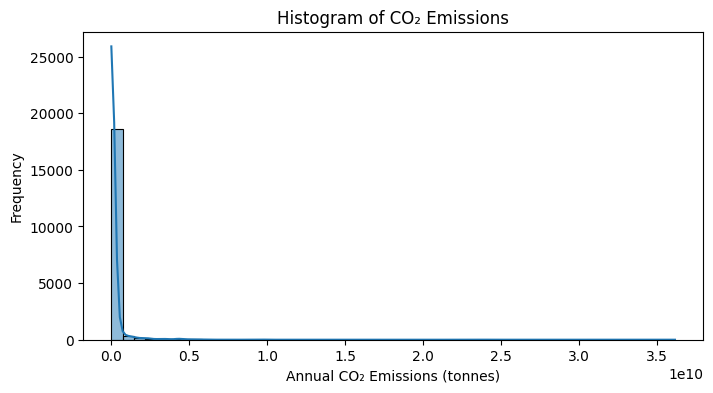

In [4]:
# Histogram
plt.figure(figsize=(8, 4))
sns.histplot(data, bins=50, kde=True)
plt.title("Histogram of CO₂ Emissions")
plt.xlabel("Annual CO₂ Emissions (tonnes)")
plt.ylabel("Frequency")
plt.show()

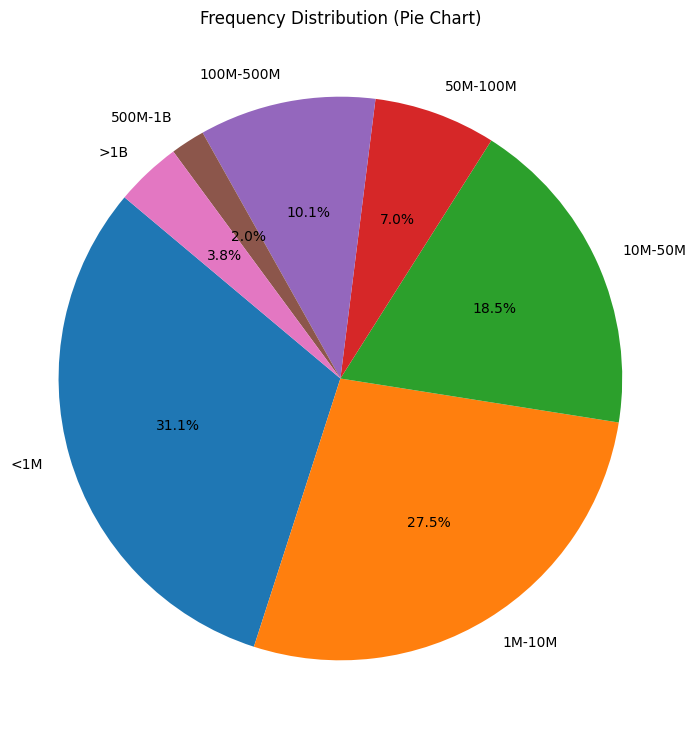

In [5]:
# Pie chart
plt.figure(figsize=(8, 9))
plt.pie(freq_dist, labels=freq_dist.index, autopct='%1.1f%%', startangle=140)
plt.title("Frequency Distribution (Pie Chart)")
plt.axis('equal')
plt.show()

In [6]:
# Task 3: Mean and Variance using Frequency Distribution
midpoints = [(bins[i] + bins[i+1]) / 2 for i in range(len(bins)-1)]
frequencies = freq_dist.values

mean_freq = sum(f * m for f, m in zip(frequencies, midpoints)) / sum(frequencies)
var_freq = sum(f * (m - mean_freq)**2 for f, m in zip(frequencies, midpoints)) / sum(frequencies)

print("\nMean from Frequency Distribution:", mean_freq)
print("Variance from Frequency Distribution:", var_freq)


Mean from Frequency Distribution: 760765067.4978232
Variance from Frequency Distribution: 1.2504002248999985e+19


In [7]:
# Task 4: 95% Confidence and Tolerance Intervals

# Split data: 80% training, 20% testing
data_shuffled = data.sample(frac=1, random_state=42).reset_index(drop=True)
split = int(0.8 * len(data_shuffled))
train = data_shuffled[:split]
test = data_shuffled[split:]

# Filter again to make sure only positive values are passed to log
train = train[train > 0]
test = test[test > 0]

# Log transformation
train_log = np.log1p(train)
test_log = np.log1p(test)

n = len(train_log)
mean_log = train_log.mean()
std_log = train_log.std(ddof=1)

# 95% Confidence Interval for Mean
conf_int = stats.t.interval(0.95, df=n-1, loc=mean_log, scale=std_log/np.sqrt(n))

# 95% Tolerance Interval (Normal approximation)
k = stats.norm.ppf(0.975)  # 95%
tol_low = mean_log - k * std_log
tol_high = mean_log + k * std_log

# Validate using test data
within_tolerance = ((test_log >= tol_low) & (test_log <= tol_high)).sum()
total_test = len(test_log)
accuracy = (within_tolerance / total_test) * 100

print("\n95% Confidence Interval for log-transformed mean:", conf_int)
print("95% Tolerance Interval (log):", (tol_low, tol_high))
print("Validation Accuracy on test set: {:.2f}%".format(accuracy))


95% Confidence Interval for log-transformed mean: (np.float64(15.29772309877553), np.float64(15.393200465471926))
95% Tolerance Interval (log): (np.float64(9.37973456952014), np.float64(21.311188994727317))
Validation Accuracy on test set: 94.57%


In [8]:
# Task 5: Hypothesis Testing
# Hypothesis: H0: μ = 16 (≈ e^16 ≈ 8.9 million tonnes), H1: μ > 16
hypothesis_mean = 16
t_stat, p_value = stats.ttest_1samp(train_log, hypothesis_mean)

print("\nHypothesis Test (mean > 16):")
print("T-statistic:", t_stat)
print("P-value:", p_value)
if p_value < 0.05:
    print("Conclusion: Reject null hypothesis (mean > 16)")
else:
    print("Conclusion: Fail to reject null hypothesis")


Hypothesis Test (mean > 16):
T-statistic: -26.87486690403605
P-value: 1.4580617800191886e-155
Conclusion: Reject null hypothesis (mean > 16)
